# Linear Regression Feature Selection and Diagnostics Pipeline

### Steps:

1. **Split into train-test sets**  
   Divide dataset into training and testing subsets.

2. **Normalize features**  
   Standardize predictors so they’re on comparable scales.

3. **Fit OLS model**  
   Estimate regression coefficients, obtain p-values, and calculate adjusted R².

4. **Compute VIF and iteratively drop features**  
   - Drop feature if **VIF > 10**, but only if adjusted R² doesn’t drop significantly.  
   - If **p-value > 0.05** or **4 < VIF ≤ 10**, use cross-validation and adjusted R² to decide.  
   - Drop one feature at a time and re-check adjusted R² impact.

5. **Check Cook’s distance and DFFITS for outliers**  
   Identify influential data points; consider dropping them (manual inspection recommended).

6. **Residual analysis for non-linearity**  
   Inspect residual plots to decide if transformations of `X` or `y` are needed.

7. **Refit model and evaluate on test set**  
   Train the refined model and report accuracy on the test data.


In [25]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:

def split_and_scale(data, target_col, test_size=0.2, seed=42):
    """
    Splits the dataset into training and testing sets.
    Then applies StandardScaler to normalize features.
    Returns scaled train/test features and labels.
    """
    X = data.drop(columns=[target_col]).copy()
    y = data[target_col].copy()

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed
    )

    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler



### 1. Fits an Ordinary Least Squares (OLS) regression using statsmodels.
### 2. Adds a constant (intercept) term to X.
### 3. Returns the fitted model object.


In [27]:
def compute_cooks_distance(X, y, threshold_factor=4):
    # Add constant term for intercept
    X_const = sm.add_constant(X)
    
    # Fit OLS model
    model = sm.OLS(y, X_const).fit()
    
    # Get Cook's distance values
    influence = model.get_influence()
    cooks_d, _ = influence.cooks_distance
       
    # Define threshold
    n = X.shape[0]
    threshold = threshold_factor / n

    # Mark points exceeding the threshold
    outliers = np.where(cooks_d > threshold)[0]
    
    # Create DataFrame for summary
    cooks_df = pd.DataFrame({
        'Index': np.arange(len(cooks_d)),
        'Cooks_Distance': cooks_d,
        'Influential': cooks_d > threshold
    })
    
    print(f"\nCooks Distance threshold: {threshold:.4f}")
    print(f"Number of Influential Points: {len(outliers)}")
    
    # Plot Cook’s distance
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x='Index', y='Cooks_Distance', data=cooks_df, hue='Influential', palette={True: 'red', False: 'blue'})
    plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold = {threshold:.4f}')
    plt.title("Cooks Distance for Each Observation")
    plt.xlabel("Observation Index")
    plt.ylabel("Cooks Distance")
    plt.legend()
    plt.show()
    
    return cooks_df, outliers

In [28]:
def fit_ols_model(X, y):
   
    X_const = sm.add_constant(X)
    model = sm.OLS(y, X_const).fit()
    return model

### Computes Variance Inflation Factor (VIF) for each feature.
### Returns a DataFrame with feature names and VIF values.


In [29]:
def calc_vif(X):
    
    X_const = sm.add_constant(X)
    vif_list = []
    for i, col in enumerate(X.columns):
        vif = variance_inflation_factor(X_const.values, i + 1)
        vif_list.append((col, vif))
    return pd.DataFrame(vif_list, columns=['feature', 'VIF']).sort_values('VIF', ascending=False).reset_index(drop=True)

In [30]:
def feature_selection(X, y, pval_limit=0.05, vif_limit=10, vif_warn=4, max_adj_r2_drop=0.05, folds=5, seed=42):
    """
    Iteratively selects features using:
      - p-values of coefficients (remove if > pval_limit)
      - VIF values (remove if > vif_limit)
      - Cross-validation RMSE and adjusted R² (drop feature only if model doesn’t worsen)

    Prints R², adjusted R², and VIFs before/after dropping each feature.
    """
    X_working = X.copy()
    selection_log = []

    round_counter = 1

    while True:
        model = fit_ols_model(X_working, y)

        # Print model summary at this step
        print(f"\n========== Iteration {round_counter} ==========")
        print(f"Features in model: {list(X_working.columns)}")
        print(f"R²: {model.rsquared:.4f}, Adjusted R²: {model.rsquared_adj:.4f}")

        # Get VIFs
        vif_table = calc_vif(X_working)
        print("\nVIF values before dropping:")
        print(vif_table)

        # Get p-values
        pvalues = model.pvalues.drop('const') if 'const' in model.pvalues.index else model.pvalues
        pvalues = pvalues.sort_values(ascending=False)
        print("p_values of feature")
        print()
        
        print(pvalues)
        # Step 1: Drop high VIF feature
        high_vif_feats = vif_table[vif_table['VIF'] > vif_limit]['feature'].tolist()
        if high_vif_feats:
            candidate = high_vif_feats[0]
            new_model = fit_ols_model(X_working.drop(columns=[candidate]), y)

            print(f"\nTrying to drop high VIF feature: {candidate}")
            print(f"Adjusted R² before: {model.rsquared_adj:.4f}, after: {new_model.rsquared_adj:.4f}")

            if new_model.rsquared_adj >= model.rsquared_adj - max_adj_r2_drop:
                print(f"Dropped feature: {candidate}")
                new_vif = calc_vif(X_working.drop(columns=[candidate]))
                print("\nVIF values after dropping:")
                print(new_vif)

                selection_log.append({
                    'action': 'drop_high_vif',
                    'feature': candidate,
                    'adj_r2_before': model.rsquared_adj,
                    'adj_r2_after': new_model.rsquared_adj
                })
                X_working = X_working.drop(columns=[candidate])
                round_counter += 1
                continue
            else:
                print(f"Retained feature {candidate} (Adjusted R² dropped too much).")

        # Step 2: Drop based on high p-value or moderate VIF
        high_p_feats = pvalues[pvalues > pval_limit].index.tolist()
        moderate_vif_feats = vif_table[(vif_table['VIF'] > vif_warn) & (vif_table['VIF'] <= vif_limit)]['feature'].tolist()

        candidates = list(set(high_p_feats + moderate_vif_feats))
        if candidates:
            worst = candidates[0]
            new_model = fit_ols_model(X_working.drop(columns=[worst]), y)

         

            print(f"\nTrying to drop candidate feature: {worst}")
            print(f"Adjusted R² before: {model.rsquared_adj:.4f}, after: {new_model.rsquared_adj:.4f}")
           

            if (new_model.rsquared_adj >= model.rsquared_adj - max_adj_r2_drop) :
                print(f"Dropped feature: {worst}")
                new_vif = calc_vif(X_working.drop(columns=[worst]))
                # print("\nVIF values after dropping:")
                # print(new_vif)

                selection_log.append({
                    'action': 'drop_candidate',
                    'feature': worst,
                    'adj_r2_before': model.rsquared_adj,
                    'adj_r2_after': new_model.rsquared_adj,
                    
                })
                X_working = X_working.drop(columns=[worst])
                round_counter += 1
                continue
            else:
                print(f"Retained feature {worst} (Adjusted R² or RMSE worsened).")

        # Stop if no more features can be dropped safely
        print("\nNo more features dropped. Final feature set:")
        print(list(X_working.columns))
        break

    return X_working, selection_log

In [31]:
# Load your CSV
data = pd.read_csv("linear_regression_3.csv")  # change to your file path

# Split & scale
X_train, X_test, y_train, y_test, scaler = split_and_scale(data, target_col="y")




In [32]:
inital_model_before_cooks_distance = fit_ols_model(X_train, y_train)
print(inital_model_before_cooks_distance.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     18.40
Date:                Mon, 13 Oct 2025   Prob (F-statistic):           5.86e-33
Time:                        12:12:27   Log-Likelihood:                -4310.9
No. Observations:                 800   AIC:                             8646.
Df Residuals:                     788   BIC:                             8702.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -41.0891      1.887    -21.776      0.0


Cooks Distance threshold: 0.0050
Number of Influential Points: 56


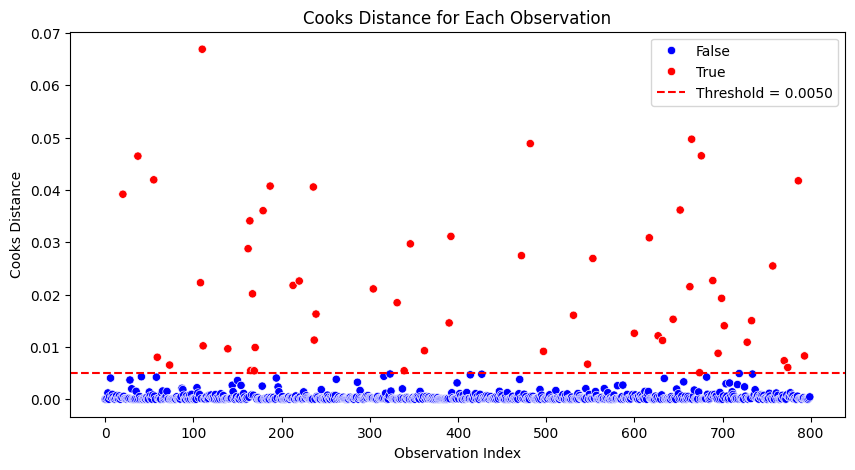

Removing 56 influential points from training data.


In [33]:
# Check Cook's distance and identify influential points
cooks_df, outliers = compute_cooks_distance(X_train, y_train)

# Remove influential points
if len(outliers) > 0:
    print(f"Removing {len(outliers)} influential points from training data.")
    X_train = X_train.drop(index=X_train.index[outliers])
    y_train = y_train.drop(index=y_train.index[outliers])
else:
    print("No influential points detected.")

# check dfits and remove points affecting

In [34]:
inital_model = fit_ols_model(X_train, y_train)
print(inital_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     326.7
Date:                Mon, 13 Oct 2025   Prob (F-statistic):          1.21e-273
Time:                        12:12:27   Log-Likelihood:                -3248.4
No. Observations:                 744   AIC:                             6521.
Df Residuals:                     732   BIC:                             6576.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -53.7263      0.707    -76.043      0.0

In [35]:
# Run feature selection
final_X, log = feature_selection(X_train, y_train)

print("\n==== Final Selected Features ====")
print(final_X.columns.tolist())



========== Iteration 1 ==========
Features in model: ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11']
R²: 0.8308, Adjusted R²: 0.8282

VIF values before dropping:
   feature           VIF
0       x4  79488.362833
1       x2  40997.152964
2       x1  37651.652119
3      x11   1417.315469
4      x10   1135.925627
5       x9    304.384190
6       x8      3.297186
7       x3      3.278796
8       x6      1.020500
9       x5      1.012797
10      x7      1.009309
p_values of feature

x1     8.063153e-01
x2     8.046949e-01
x4     6.909968e-01
x10    4.854994e-01
x9     4.719144e-01
x11    4.623035e-01
x7     8.970906e-02
x8     6.386972e-02
x5     5.332417e-03
x3     5.855298e-29
x6     6.576601e-50
dtype: float64

Trying to drop high VIF feature: x4
Adjusted R² before: 0.8282, after: 0.8284
Dropped feature: x4

VIF values after dropping:
  feature          VIF
0     x11  1416.923657
1     x10  1135.667815
2      x9   304.259423
3      x8     3.291042
4      x3     3.27

In [36]:
# # Check Cook's distance and identify influential points
# cooks_df, outliers = compute_cooks_distance(final_X, y_train)

# # Remove influential points
# if len(outliers) > 0:
#     print(f"Removing {len(outliers)} influential points from training data.")
#     final_X = final_X.drop(index=final_X.index[outliers])
#     y_train = y_train.drop(index=y_train.index[outliers])
# else:
#     print("No influential points detected.")

# # check dfits and remove points affecting

In [37]:
# Fit final OLS model
final_model = fit_ols_model(final_X, y_train)
print("\nFinal Model Summary:")
print(final_model.summary())

# Prepare test set using same features
X_test = X_test[final_X.columns]

# Predict on test data
y_pred = final_model.predict(sm.add_constant(X_test))


Final Model Summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     713.4
Date:                Mon, 13 Oct 2025   Prob (F-statistic):          9.53e-280
Time:                        12:12:27   Log-Likelihood:                -3253.2
No. Observations:                 744   AIC:                             6518.
Df Residuals:                     738   BIC:                             6546.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -53.7762      0.7

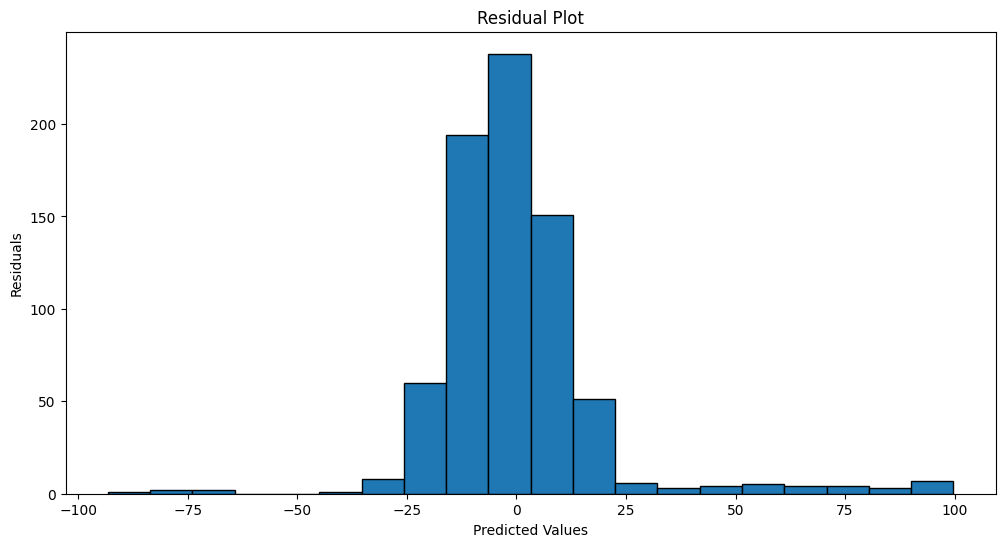

In [38]:
# plot residuals on train data
y_train_pred = final_model.predict(sm.add_constant(final_X))


plt.figure(figsize=(12,6))
plt.hist(y_train - y_train_pred, bins=20, edgecolor='black')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [39]:
# Calculate R^2 on test data
from sklearn.metrics import r2_score

# y_pred = final_model.predict(X_test)
before_outliers_r2 = r2_score(y_test, y_pred)
before_outliers_adjusted_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)
print(before_outliers_r2)
print(before_outliers_adjusted_r2)

NameError: name 'r2' is not defined

In [ ]:
# plot residual from test data
# import matplotlib.pyplot as plt

residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=20, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

In [ ]:
# removing outliers from test data using residuals z_score
def z_score(data):
    mean = data.mean()
    std = data.std()
    return (data - mean) / std if std else 0

    

z_scores = np.abs(z_score(residuals))
threshold = 2
outliers = np.where(z_scores > threshold)[0]
print(len(outliers))
X_test_without_outlier = X_test.drop(X_test.index[outliers])
y_test_without_outlier = y_test.drop(y_test.index[outliers])
print(X_test_without_outlier.shape)
y_pred_without_outlier = final_model.predict(sm.add_constant(X_test_without_outlier))

after_outliers_r2 = r2_score(y_test_without_outlier, y_pred_without_outlier)
after_outliers_adjusted_r2 = 1 - (1 - after_outliers_r2) * (len(y_test_without_outlier) - 1) / (len(y_test_without_outlier) - X_test_without_outlier.shape[1] - 1)
print(after_outliers_r2)
print(after_outliers_adjusted_r2)

residuals_after_outliers = y_test_without_outlier - y_pred_without_outlier
plt.scatter(y_pred_without_outlier, residuals_after_outliers)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()